_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/GRB_ML)._

# Swift Data Noise Reduction
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

Swift data are **particularly noisy**, and taking more cleaned light curves for t-SNE can refine its results. This notebook summarizes how to reduce noise from Swift Data using non-parametric noise reduction technique implemented on [FABADA](https://github.com/PabloMSanAla/fabada). Through this document, we are using the _python3_ implementations from the _scripts_ folder. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the **main.py** file to our notebook (and some packages needed):

In [1]:
from scripts import main
from prettytable import PrettyTable  # Import module to do tables
import os  # Import os to handle folders and files
import numpy as np  # Import numpy module to read tables, manage data, etc

Then, create a new object from the `main.py` class and, if you need, set the data, table and results folder paths (by default it will be the "Data", "Table", and "Results" folders inside the path containing this notebook):

In [2]:
%matplotlib inline
object1 = main.SwiftGRBWorker()
object1.original_data_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Data\Original_Data'  # Change original data path
object1.table_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Tables'  # Change table path
object1.results_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Results'  # Change results path
object1.noise_data_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Data\Noise_Filtered_Data'
object1.noise_images_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Results\Noise_Filter_Images'

## Changing the Swift GRB binning
By default, this notebook preprocesses the data for 64ms binning in Swift. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ and _end_ variables.

Through this package, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $1$ for 1s binning and change the end variable to "sn5_10s" to use data with a signal-to-noise ratio higher than 5 or 10 s binning (these data don't have uniform time spacing).

In [3]:
object1.res = 64  # Resolution for the Light Curve Data in ms, could be 2, 8, 16, 64 (default), 256 and 1 (this last in s)
# object1.end = "sn5_10s"  # Uncomment this line if you need to use signal-to-noise higher than 5 or 10s binning

It is advisable not to change both variables at the same time; this could cause unknown bugs when running package routines and sub-routines. Additionally, you will need the data downloaded for the selected binning.

Last, from the download section, extract the GRB Names filtered by download error:

In [4]:
sum_general_path = os.path.join(object1.table_path, "summary_general.txt")  # Path to summary table
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True, autostrip=True)  # GRB Names total array
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]

If you haven't downloaded the data yet, check the _Swift_Data_Download_ notebook.

## Fully Adaptive Bayesian Algorithm for Data Analysis - FABADA
Taked from their GitHub:
_FABADA is a novel non-parametric noise reduction technique which arise from the point of view of Bayesian inference that iteratively evaluates possible smoothed models of the data, obtaining an estimation of the underlying signal that is statistically compatible with the noisy measurements. (...) **The only requisite of the input data is an estimation of its associated variance**._

As you can read, we need to estimate variance prior to implementing FABADA. To do this, we use the method based on _[John Immerkær(1996)](https://www.semanticscholar.org/paper/Fast-Noise-Variance-Estimation-Immerk%C3%A6r/1da5c5819ae1d33a2a4acc57e16cb655374054e7)_; it consists of a simple function (saved on helpers script) that takes one light curve band array as a 1 pixel gray-scaled image. To prevent disturbing estimation by the GRB itself, we use only the data outside $T_{100}$.

Through the `noise_reduction_fabada` instance, we can reduce the noise of anything GRB in the dataset only by introducing its name:

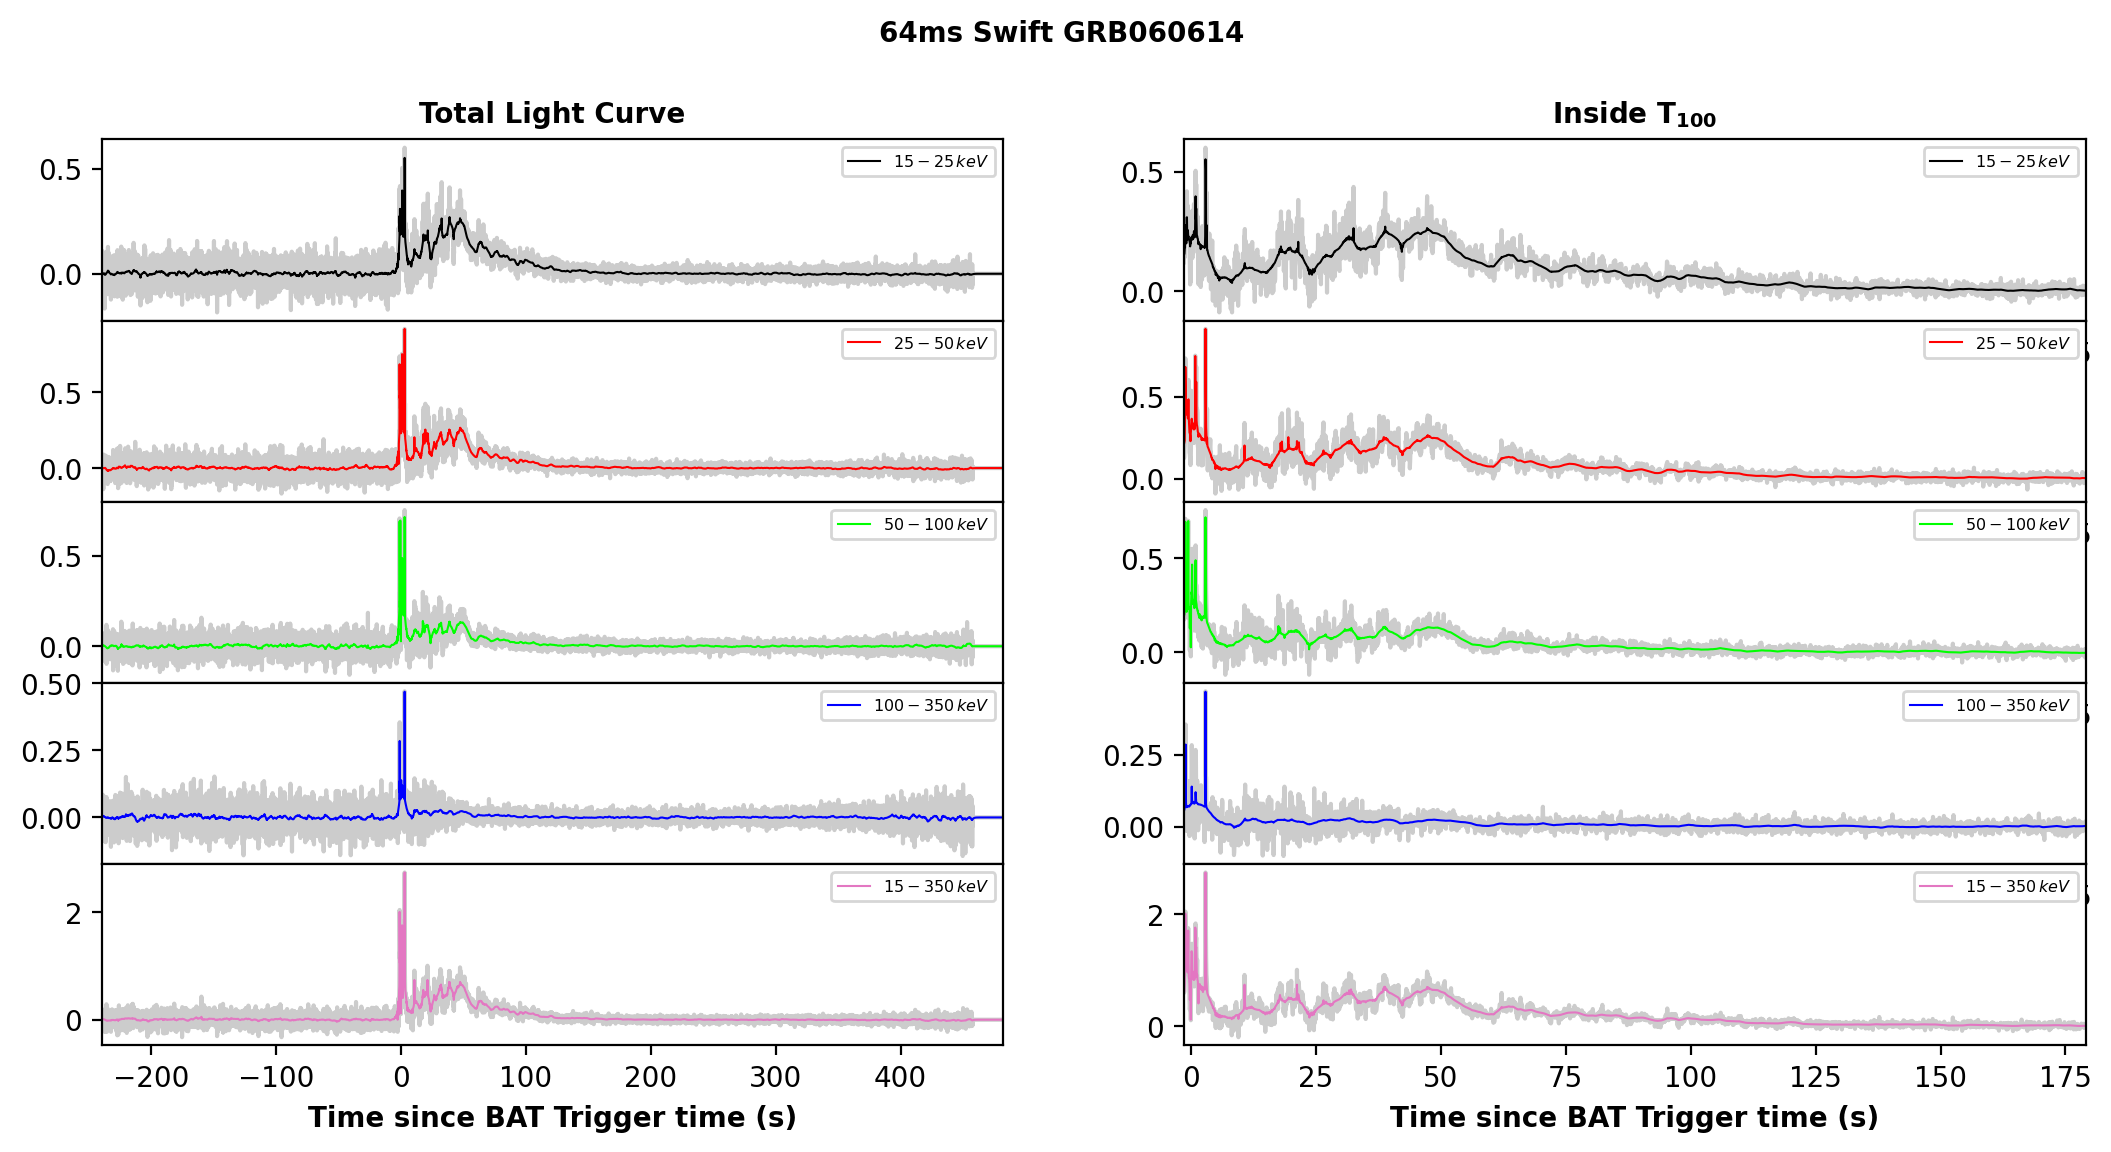

In [5]:
name = 'GRB060614'
reduced_noise_data, fig = object1.noise_reduction_fabada(name, plot=True, save_fig=False)

As you can see, the gray background represents the original data, and colored lines the noise filtered results (the plot is saved automatically in the results' directory). In general, the noise reduction is satisfactory and reveals a problem: GRBs with low signal-to-noise ratios seem like only random noise. Check (for example) the GRB060203 results:

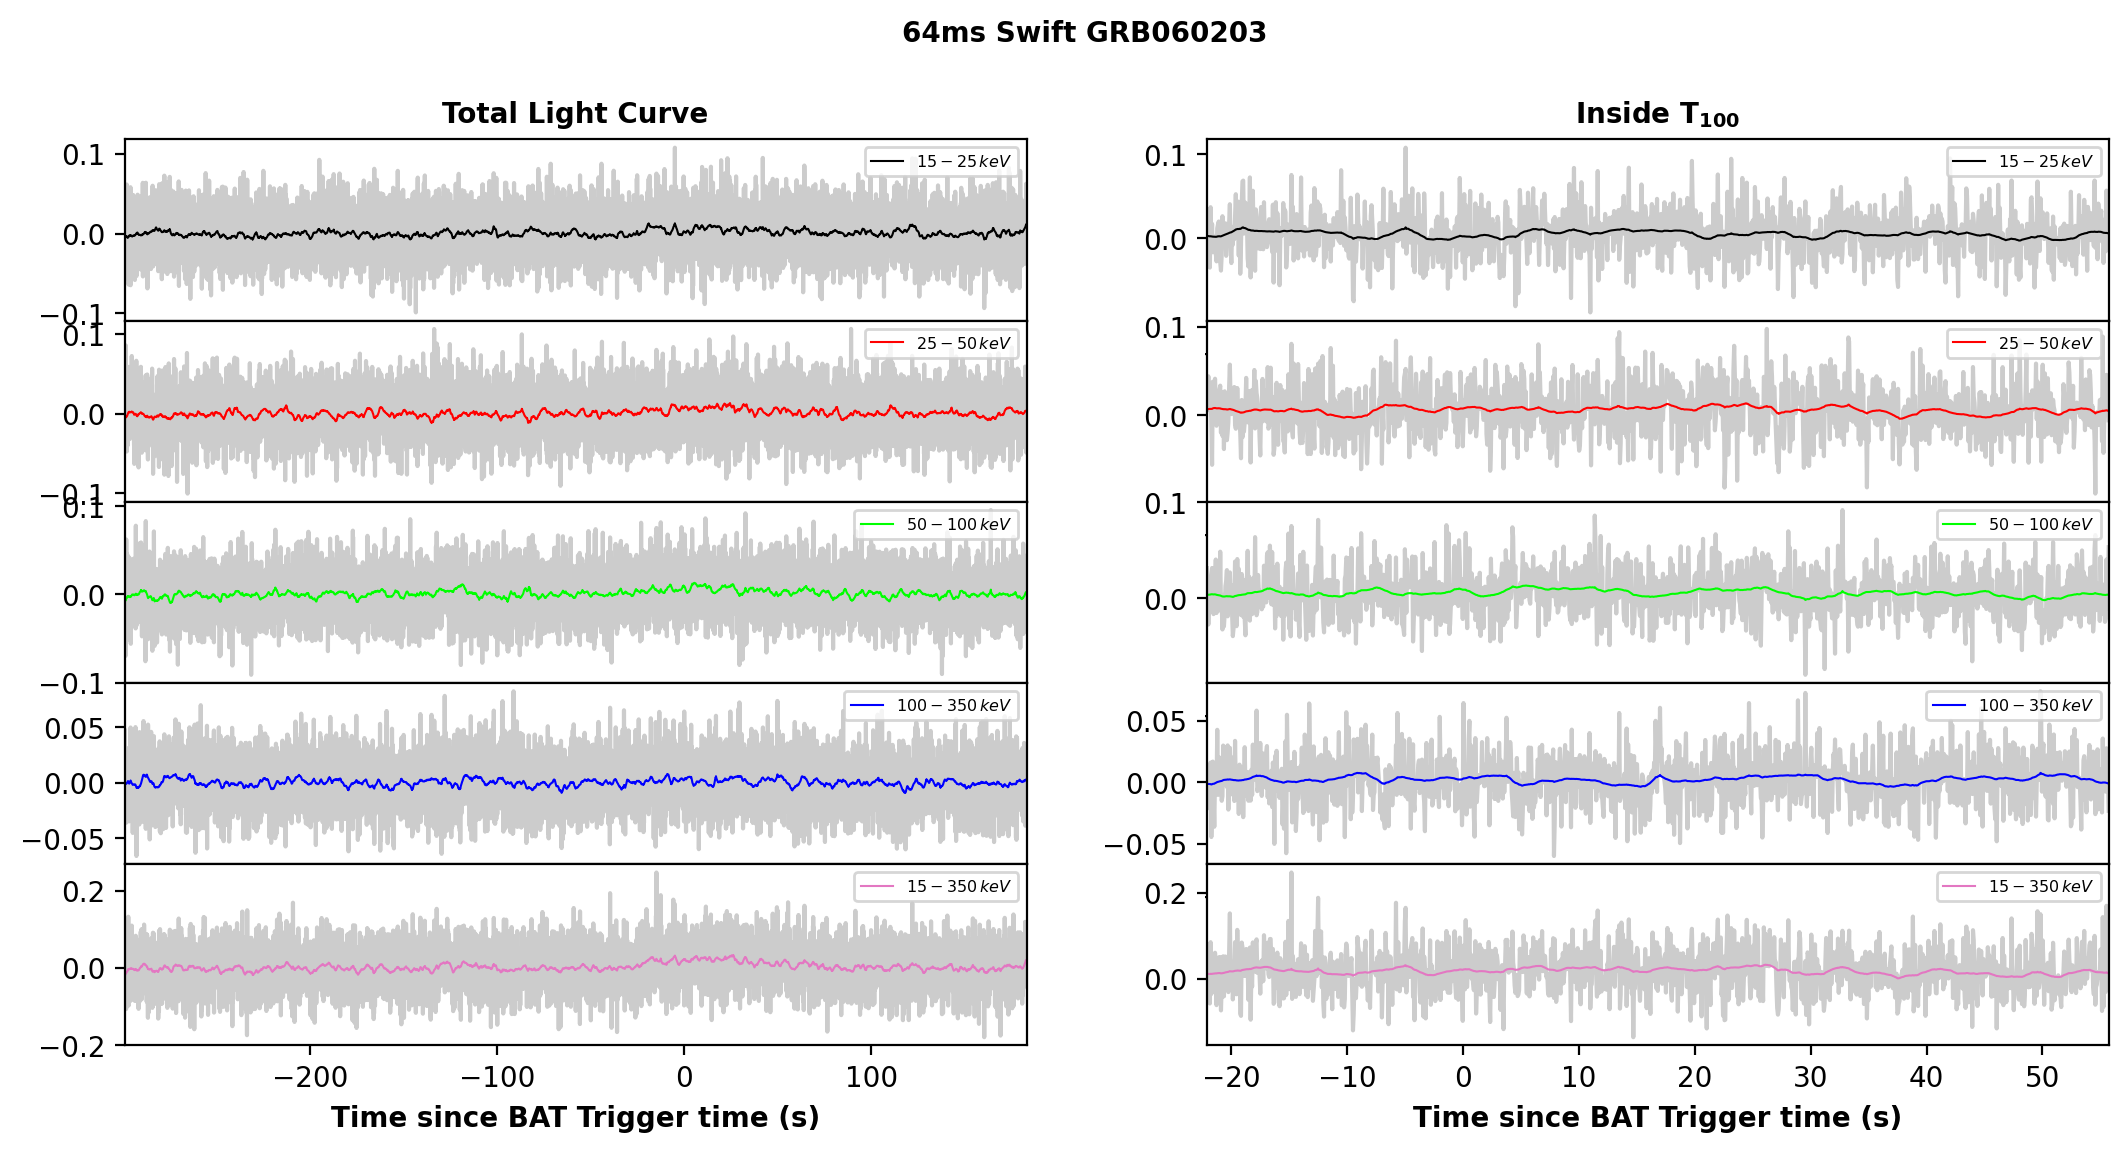

In [6]:
reduced_noise_data_2, fig_2 = object1.noise_reduction_fabada('GRB060203', plot=True, save_fig=False)

Beyond this fact, we can parallelize the noise reduction using the `so_much_noise_filtering` instance (enable the `save_data` parameter to keep results in the data directory):

In [7]:
# object1.so_much_noise_filtering(names=GRB_names, save_data=True, plot=False)  # Make plot=True if you need to save plots

## Pre-processing procedure
With the noise-filtered data, we need to pre-process it to use on t-SNE. The main idea is to change the _original_data_path_ to the noise filtered data path and follows the same methods from the _Data_Preprocessing_ notebook:

In [8]:
object1.original_data_path = object1.noise_data_path  # Change data path temporally

* **Limit out of $T_{100}$:**

In [9]:
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)

LC Limiting: 100%|██████████| 1369/1369 [09:03<00:00,  2.52GRB/s]


+------------+---------+-------+-------------------+
|    Name    | t_start | t_end |     Error Type    |
+------------+---------+-------+-------------------+
| GRB200324A |         |       |     ValueError    |
| GRB190326A |         |       | FileNotFoundError |
| GRB180718A |         |       | FileNotFoundError |
| GRB170906B |         |       | FileNotFoundError |
| GRB170524A |         |       | FileNotFoundError |
| GRB170112A |         |       | FileNotFoundError |
| GRB161104A |         |       | FileNotFoundError |
| GRB160601A |         |       | FileNotFoundError |
| GRB160525A |         |       |     ValueError    |
| GRB160501A |         |       |     ValueError    |
| GRB151107A |         |       |     ValueError    |
| GRB150710B |         |       |     ValueError    |
| GRB150424A |         |       |     IndexError    |
| GRB150101B |         |       | FileNotFoundError |
| GRB150101A |         |       | FileNotFoundError |
| GRB141102A |         |       | FileNotFoundE

The _FileNotFoundError_ corresponds to GRBs with less than 3 datapoints between $T_{100}$.

* **Normalize data**

In [10]:
normalized_data = object1.so_much_normalize(limited_data)  # Normalizing all light curves

LC Normalizing: 100%|██████████| 1318/1318 [00:27<00:00, 47.44GRB/s] 


* **Zero-pad data**

In [11]:
zero_padded_data = object1.so_much_zero_pad(normalized_data)

LC Zero-Padding: 100%|██████████| 1318/1318 [00:33<00:00, 39.08GRB/s] 


* **Concatenate without DFT**

In [12]:
concatenated_data = object1.so_much_concatenate(zero_padded_data)  # Concatenate data without DFT

Concatenating: 100%|██████████| 1318/1318 [00:38<00:00, 33.93GRB/s]


* **Perform DFT**

In [13]:
pre_processing_data = object1.so_much_fourier(zero_padded_data)

Performing DFT: 100%|██████████| 1318/1318 [00:42<00:00, 30.89GRB/s]


* **Save results**

In [14]:
object1.save_data(f"DFT_Noise_Filtered_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save data with DFT
object1.save_data(f"non_DFT_Noise_Filtered_data_{object1.end}", names=GRB_names, data=concatenated_data)  # Save data without DFT